In [1]:
# Created on Sun Aug 13 13:14:06 2023

# @author: katelynsmith

import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Times New Roman"
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
#plt.style.use(['no-latex']) 
#from emcee import MASER
import glob
import os 
import pandas as pd

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import LombScargle

import scipy.signal as sps

import maser as ms
import starspot as ss
import astrobase as ab
#from astrobase import periodbase


from tqdm import tqdm 
# Setting directory

ddir = '/Users/katelynsmith/Desktop/Capstone/'

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import curve_fit



/Users/katelynsmith/opt/anaconda3/envs/example/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Defining variables 

M_s = 0.5 # Star mass (solar masses) #### REFERENCE (PAPER 6 on one note) #####
R_s = 0.75 # Star radius (solar radii) ####  REFERENCE (PAPER 6 on one note) ####
P_s = 4.86 # Star rotation period (days) ####  REFERENCE (PAPER 6 on one note) ####
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) ####  ACCORDING TO MEETING WITH BEN ####
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) #### https://arxiv.org/pdf/2304.09642.pdf #### 
beta = 20 # Star magnetic obliquity (degrees) #### ACCORDING TO MEETING WITH BEN ####
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1) <<<<<< LEFT AS IS
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE (PAPER 6 on one note) ####
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees) #### REFERENCE (PAPER 7 on one note) #### 
lam = 0 # Planet projected spin-orbit angle (degrees) #### ranging from -15 to 18 degrees 
#REFERENCE Spin-orbit alignment and magnetic activity in the young planetary system AU Mic⋆ ####
P_p = 8.4630351 # AU Mic b period in days
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) <<<<< LEFT AS IS
f = 10 # Emission observing frequency (MHz) #### - MAY INCREASE TO 3 GHz REFERENCE (PAPER 6 on one note) ####
alpha = 75 # Emission cone opening angle (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023
dalpha = 5 # Emission cone thickness (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023

In [3]:
def get_events(t, vis):
    ups = np.where(np.diff(vis,1) > 0)[0]+1
    downs = np.where(np.diff(vis,1) < 0)[0]

    if ups[0] > downs[0]:
        downs = np.delete(downs,0)
    elif ups[-1] > downs [-1]:
        ups = np.delete(ups,-1)
    
    full_length = np.min([len(ups),len(downs)])
    ups, downs = ups[:full_length], downs[:full_length]

    durations = t[downs] - t[ups]
    centres = t[ups] + durations/2

    return centres, durations

In [4]:
def group_events(central_points):
    durations = np.diff(central_points)
    central_points = central_points[:-1] + durations/2

    return durations, central_points

In [5]:
#def period(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, interval):
def period(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times):
   north_vis, south_vis = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)

   visibility_North = north_vis*1.0
   visibility_South = south_vis*1.0

   if np.count_nonzero(visibility_North) > 0:
      ind_centres_N, ind_durations_N = get_events(times, visibility_North)
      g_centres_N, g_durations_N = group_events(ind_centres_N)
      minima_N = np.where(np.abs(g_centres_N - np.min(g_centres_N)) < 0.01)[0]
      middles_N = [(minima_N[i] + minima_N[i+1])/2 for i in range(0, len(minima_N)-1, 1)]
      true_durations_N, timings_N = group_events(middles_N)

      x = g_durations_N 
      y = (g_centres_N/g_centres_N.max())

      LS = LombScargle(x, y) # initialize a Lomb-Scargle algorithm from Astropy
      freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
      power = LS.power(freqs) # calculate LS power

      lombscargle_period_N = 1/freqs[np.argmax(power)] # calculate period from LS power

     #est_true_period_N = np.median(true_durations_N)
      first_spacing_N = np.median(ind_centres_N)
      first_g_spacing_N = np.median(g_centres_N)
      mean_durations_N = np.median(true_durations_N)

      
   else:
      lombscargle_period_N = np.nan
      first_spacing_N = np.nan
      mean_durations_N = np.nan
      first_g_spacing_N = np.nan
      

   if np.count_nonzero(visibility_South) > 0:
      ind_centres_S, ind_durations_S = get_events(times, visibility_South)
      g_centres_S, g_durations_S = group_events(ind_centres_S)
      minima_S = np.where(np.abs(g_centres_S - np.min(g_centres_S)) < 0.01)[0]
      true_durations_S, timings_S = group_events(minima_S)

      x = g_durations_S 
      y = (g_centres_S/g_centres_S.max())

      LS = LombScargle(x, y) # initialize a Lomb-Scargle algorithm from Astropy
      freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
      power = LS.power(freqs) # calculate LS power

      lombscargle_period_S = 1/freqs[np.argmax(power)] # calculate period from LS power

      #est_true_period_S = np.median(true_durations_S)
      first_spacing_S = np.median(ind_centres_S)
      mean_durations_S = np.mean(true_durations_S)
      first_g_spacing_S = np.median(g_centres_S)
   else:
      lombscargle_period_S = np.nan
      first_spacing_S = np.nan
      mean_durations_S = np.nan
      first_g_spacing_S = np.nan

   return lombscargle_period_N, lombscargle_period_S, first_spacing_N, first_spacing_S, mean_durations_N, mean_durations_S, first_g_spacing_N, first_g_spacing_S
   #return visibility_North, visibility_South, mean_durations_N, mean_durations_S, g_centres_N, g_centres_S, g_durations_N, g_durations_S, ind_centres_N, ind_centres_S, minima_N, minima_S
   #return est_true_period_N, est_true_period_S, mean_durations_N, mean_durations_S, first_spacing_N, first_spacing_S, first_g_spacing_N, first_g_spacing_S, g_centres_N, g_centres_S, g_durations_N, g_durations_S
   #return acf_period_N, acf_period_S, est_true_period_N, est_true_period_S, mean_durations_N, mean_durations_S, first_spacing_N, first_spacing_S, first_g_spacing_N, first_g_spacing_S
   #return acf_period_N, est_true_period_N, mean_durations_N, first_spacing_N, first_g_spacing_N

In [6]:
times = np.linspace(0,100,40000)

est_true_period_N, est_true_period_S, mean_durations_N, mean_durations_S, first_spacing_N, first_spacing_S, first_g_spacing_N, first_g_spacing_S, g_centres_N, g_centres_S, g_durations_N, g_durations_S = period(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)

ValueError: not enough values to unpack (expected 12, got 8)

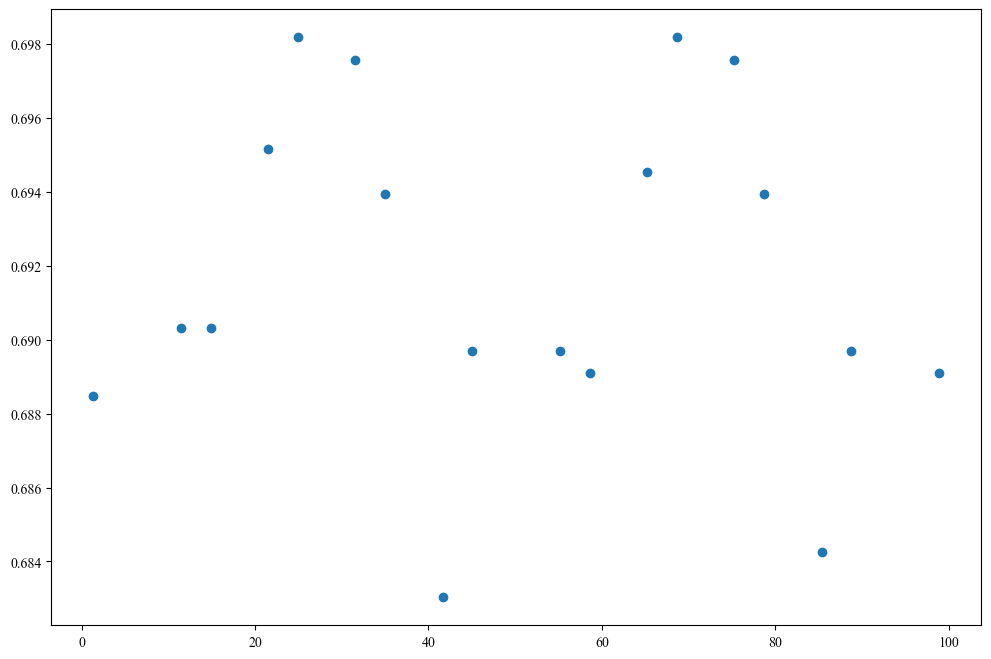

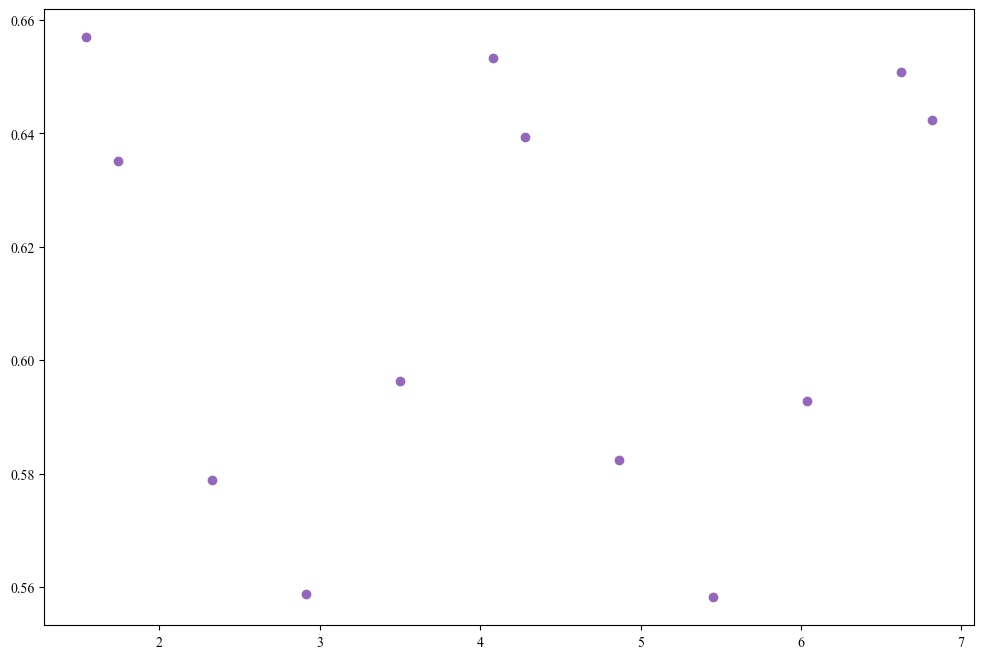

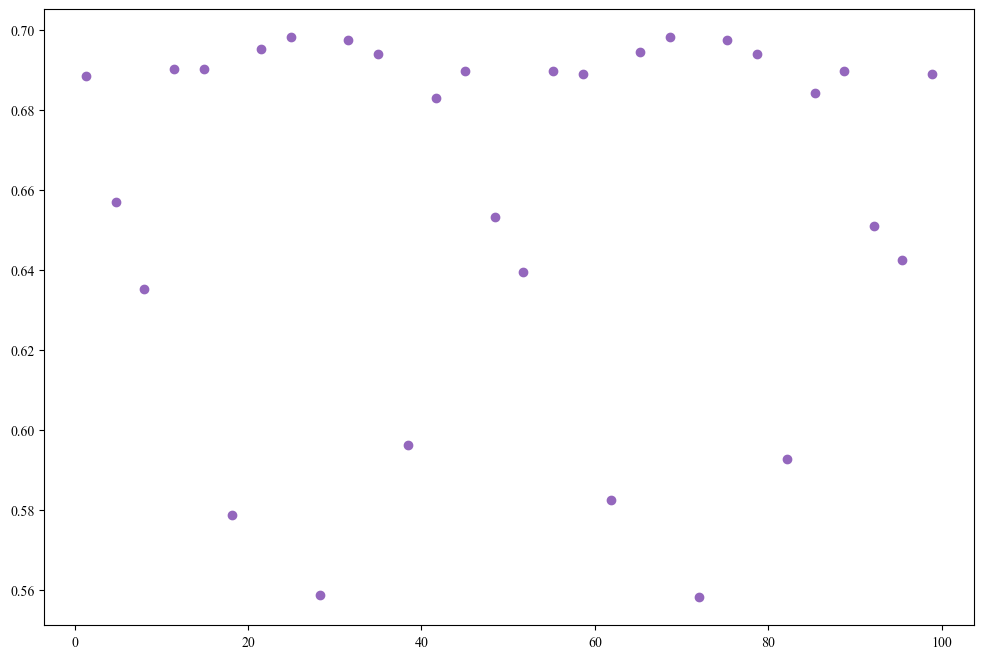

In [ ]:
relative_spacings = np.array((g_centres_S/g_centres_S.max()))


t = np.linspace(np.min(g_durations_S), np.max(g_durations_S), 1000)
fig = plt.figure(figsize=(12.0,8.0))
smallish_spactings_t = []
smallish_rel_spacings = []
for ind, val in enumerate(relative_spacings):
    if val > 0.66 and val < 0.8:
        smallish_spactings_t.append(g_durations_S[ind])
        smallish_rel_spacings.append(val)
        plt.plot(g_durations_S[ind], val, 'o', color='C0')
plt.show()
smallest_spactings_t = []
smallest_rel_spacings = []
fig = plt.figure(figsize=(12.0,8.0))
for ind, val in enumerate(relative_spacings):
    if val < 0.66:
        smallest_spactings_t.append(g_durations_S[ind])
        smallest_rel_spacings.append(val)
        plt.plot(t[ind], val, 'o', color='C4')
plt.show()


fig = plt.figure(figsize=(12.0,8.0))

small_spacing_t = []
rel_small_spacings = []
for ind, val in enumerate(relative_spacings):
    if val < 0.8:
        times_values = g_durations_S[ind]
        rel_spacings = val
        small_spacing_t.append(times_values)
        rel_small_spacings.append(rel_spacings)
        plt.plot(times_values, rel_spacings, 'o', color='C4')
       # plt.plot(g_durations_S[ind], val, 'o', color='C5')
plt.show()






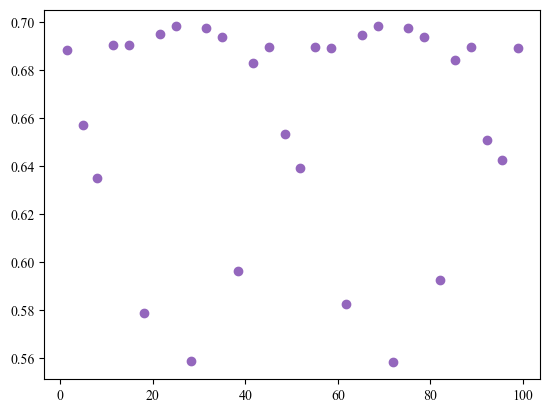

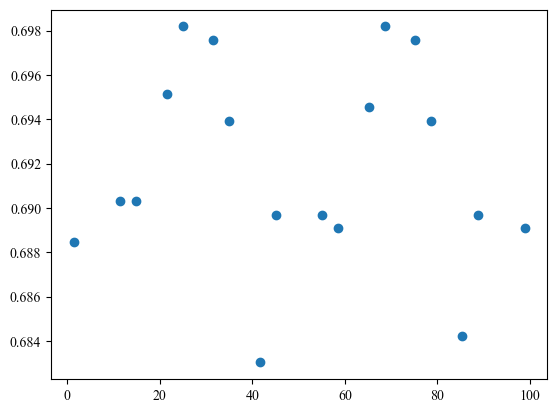

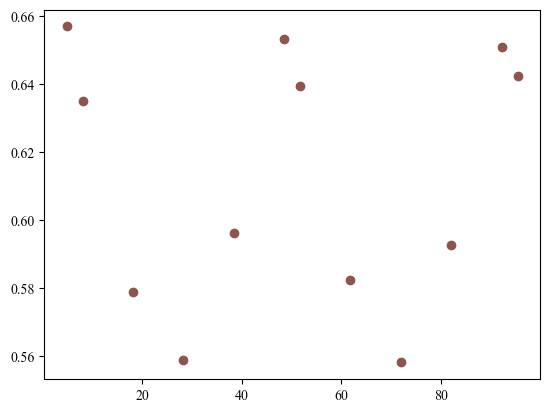

In [ ]:
plt.plot(small_spacing_t, rel_small_spacings, 'o', color='C4')
plt.show()

plt.plot(smallish_spactings_t, smallish_rel_spacings, 'o', color='C0')
plt.show()

plt.plot(smallest_spactings_t, smallest_rel_spacings, 'o', color='C5')
plt.show()

In [ ]:
diff1 = max(smallest_rel_spacings) - min(smallest_rel_spacings)
amplitude1 = diff1/2
center1 = diff1
print(amplitude1)
print(center1)


diff2 = max(smallish_rel_spacings) - min(smallish_rel_spacings)
amplitude2 = diff2/2
center2 = diff2
print(amplitude2)
print(center2)

0.049393939393935216
0.09878787878787043
0.00757575757575818
0.01515151515151636


[0.00270972 0.00287802 0.15915804 0.00226104]


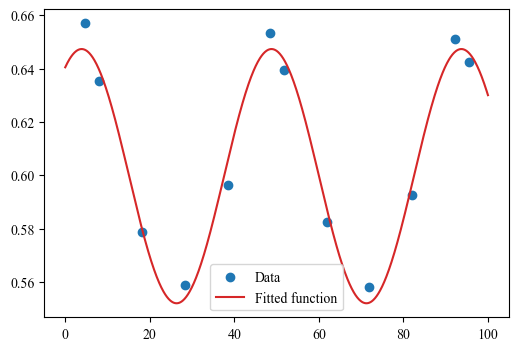

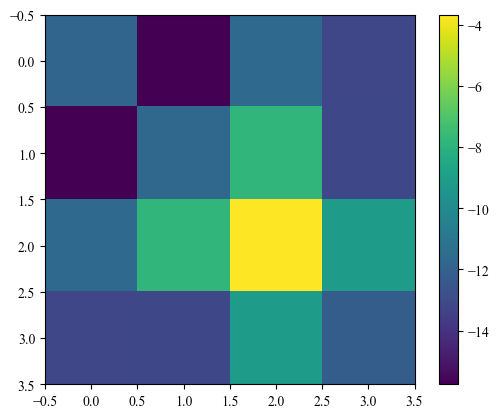

The smallest fitted function is:0.047664220575521554 * sin(0.1398904301887812 * x - 5.255082609400709) + 0.5996463381851518


In [ ]:
x = smallest_spactings_t
y = smallest_rel_spacings

x_data = np.linspace(0, 100, num=1000)

def model_f(x, a, b, c, d):
    return a * np.sin(b * x - c) + d

popt, pcov = curve_fit(model_f, x, y, p0=[60,0.1, 2, 1])

parameter_unc = np.sqrt(np.diag(pcov))
print(parameter_unc)

a_opt, b_opt, c_opt, d_opt = popt

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data')
plt.plot(x_data, model_f(x_data, popt[0], popt[1], popt[2], popt[3]),
         label='Fitted function', color='C3')

plt.legend(loc='best')

plt.show()

plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()


print("The smallest fitted function is:" + str(a_opt) + " * sin(" + str(b_opt) + " * x - " + str(c_opt) + ") + " + str(d_opt))


[0.00087291 0.0051488  0.29891632 0.00059844]


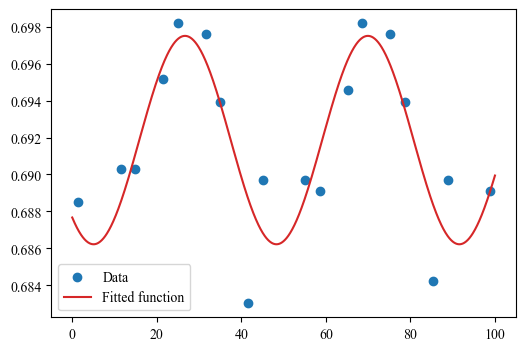

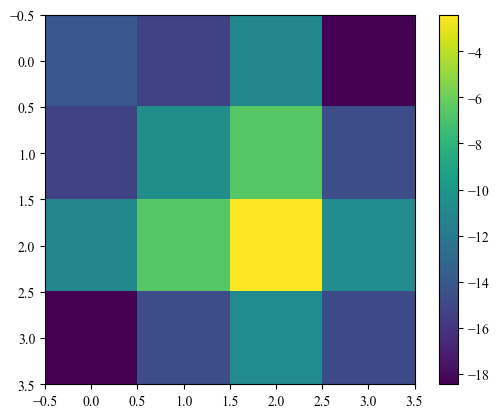

The smallish fitted function is:-0.005638549552986901 * sin(0.14522937971056477 * x - -0.837710445886876) + 0.6918618793667128


In [ ]:
x = smallish_spactings_t
y = smallish_rel_spacings

x_data = np.linspace(0, 100, num=1000)

def model_f(x, a, b, c, d):
    return a * np.sin(b * x - c) + d

popt, pcov = curve_fit(model_f, x, y, p0=[100,0.2, 3, 0.02])

parameter_unc = np.sqrt(np.diag(pcov))
print(parameter_unc)


a_opt, b_opt, c_opt, d_opt = popt

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data')
plt.plot(x_data, model_f(x_data, popt[0], popt[1], popt[2], popt[3]),
         label='Fitted function', color='C3')

plt.legend(loc='best')

plt.show()

plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()

print("The smallish fitted function is:" + str(a_opt) + " * sin(" + str(b_opt) + " * x - " + str(c_opt) + ") + " + str(d_opt))


[0.02092282 0.04232903 2.52458738 0.04625498 2.62827572 0.00927634]


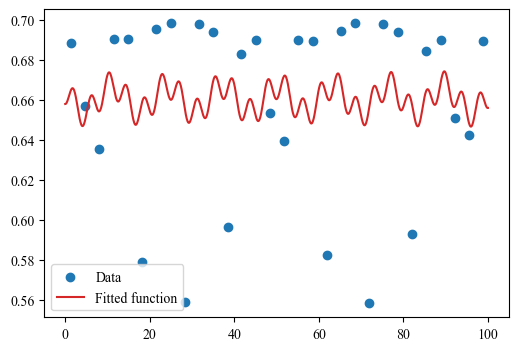

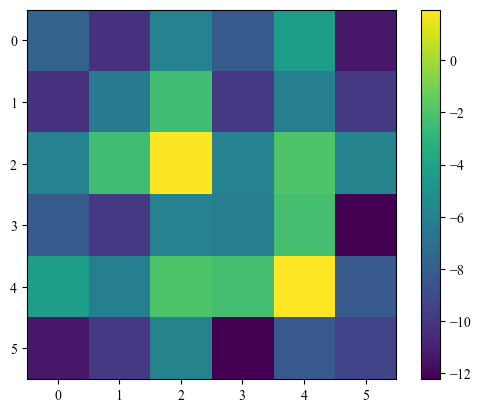

In [ ]:
x = small_spacing_t
y = rel_small_spacings

x_data = np.linspace(0, 100, num=1000)

def model_f(x, a, b, c, d, e, f):
    return a * np.sin(b * x - c)*np.cos(d*x - e) + f

popt, pcov = curve_fit(model_f, x, y, p0=[70,0.5, 3, 1, 2, 0])

parameter_unc = np.sqrt(np.diag(pcov))
print(parameter_unc)


a_opt, b_opt, c_opt, d_opt, e_opt, f_opt = popt

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data')
plt.plot(x_data, model_f(x_data, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]),
         label='Fitted function', color='C3')

plt.legend(loc='best')

plt.show()

plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()



In [7]:
betas = np.linspace(beta*0.5, beta*4, 10) # 50 and beta*2
inclinations = np.linspace(i_s*0.5, i_s*4, 10) # 50 and i_s*2
times = np.linspace(0,100,40000)


for j, b in (enumerate(tqdm(betas))):
    for k, inc in enumerate(inclinations):  
        visibility_North, visibility_South, mean_durations_N, mean_durations_S, g_centres_N, g_centres_S, g_durations_N, g_durations_S, ind_centres_N, ind_centres_S = period(M_s, R_s, P_s, inc, B_s, b, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)


fig, ax = plt.subplots(2,1, figsize=(12.0,8.0))
ax[0].plot(times, visibility_North, color='C0')
ax[0].plot(ind_centres_N, np.ones_like(ind_centres_N), 'o', color='C0', label='North events')
ax[0].plot(g_durations_N, (g_centres_N/g_centres_N.max()), '--o', color='C3', label='First grouping north')
for cen in g_durations_N[minima_N]:
    ax[0].axvline(cen, color='C3', linestyle='--')
    ax[1].plot(times, visibility_South, color='C1')
    ax[1].plot(ind_centres_S, np.ones_like(ind_centres_S), 'o', color='C1', label='South events')
    ax[1].plot(g_durations_S, (g_centres_S/g_centres_S.max()), '--o', color='C4', label='First grouping south')
for cen in g_durations_S[minima_S]:
    ax[1].axvline(cen, color='C4', linestyle='--')

plt.xlim(0,100)
plt.tight_layout()
fig.subplots_adjust(right=0.8)
ax[1].set_xlabel('Time (days)', fontsize=14)
ax[0].set_ylabel('Relative emission spacing (days)', fontsize=14)
ax[1].set_ylabel('Relative emission spacing (days)', fontsize=14)

plt.show()

  0%|          | 0/10 [00:03<?, ?it/s]


ValueError: not enough values to unpack (expected 10, got 8)

In [ ]:
import numpy as np
P_p = 8.4630351 # AU Mic b period in days
P_s = 4.86 # Star rotation period (days) ####  REFERENCE (PAPER 6 on one note) ####
synodic = np.abs(1/(1/P_p - 1/P_s))
print('Synodic period %.2f days' % synodic)

Synodic period 11.42 days


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12.0,8.0))
ax[0].plot(times, visibility_North, color='C0')
ax[0].plot(ind_centres_N, np.ones_like(ind_centres_N), 'o', color='C0', label='North events')
ax[0].plot(g_durations_N, (g_centres_N/g_centres_N.max()), '--o', color='C3', label='First grouping north')
for cen in g_durations_N[minima_N]:
    ax[0].axvline(cen, color='C3', linestyle='--')
    ax[1].plot(times, visibility_South, color='C1')
    ax[1].plot(ind_centres_S, np.ones_like(ind_centres_S), 'o', color='C1', label='South events')
    ax[1].plot(g_durations_S, (g_centres_S/g_centres_S.max()), '--o', color='C4', label='First grouping south')
for cen in g_durations_S[minima_S]:
    ax[1].axvline(cen, color='C4', linestyle='--')

plt.xlim(0,100)
plt.tight_layout()
fig.subplots_adjust(right=0.8)
ax[1].set_xlabel('Time (days)', fontsize=14)
ax[0].set_ylabel('Relative emission spacing (days)', fontsize=14)
ax[1].set_ylabel('Relative emission spacing (days)', fontsize=14)

plt.show()

[1.36378409 1.90879772 1.48378709 1.96504913 1.47253681 1.93379834
 1.37753444 1.82504563 1.49878747 1.97004925 1.45128628 1.97129928
 1.43878597 1.75879397 1.47878697 1.97504938 1.44628616 1.97379934
 1.49128728 1.77379434 1.41628541 1.96379909 1.45753644 1.96879922
 1.49503738 1.85379634 1.36503413 1.91504788 1.480037   1.96504913
 1.47503688 1.93004825 1.37503438 1.83004575 1.49753744 1.97004925
 1.45253631 1.97004925 1.43503588 1.76129403 1.48128703 1.97504938
 1.44503613 1.97504938 1.48878722 1.77004425 1.42253556 1.96504913
 1.45503638 1.96879922 1.49628741 1.84879622 1.36753419 1.91754794
 1.47878697 1.96504913 1.47628691 1.92754819 1.37253431]


In [ ]:
betas = np.linspace(beta*0.5, beta*4, 100) # 50 and beta*2
inclinations = np.linspace(i_s*0.5, i_s*4, 100) # 50 and i_s*2
times = np.linspace(0,100,40000)

period_grid = np.zeros((len(betas), len(inclinations),2))
first_spacing_grid = np.zeros((len(betas), len(inclinations),2))
mean_durations_grid = np.zeros((len(betas), len(inclinations),2))
first_g_spacing_grid = np.zeros((len(betas), len(inclinations),2))
for j, b in (enumerate(tqdm(betas))):
    for k, inc in enumerate(inclinations):  
        lombscargle_period_N, lombscargle_period_S, first_spacing_N, first_spacing_S, mean_durations_N, mean_durations_S, first_g_spacing_N, first_g_spacing_S = period(M_s, R_s, P_s, inc, B_s, b, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)
        period_grid[j,k, :] = lombscargle_period_N, lombscargle_period_S
        first_spacing_grid[j,k, :] = first_spacing_N, first_spacing_S
        mean_durations_grid[j,k, :] = mean_durations_N, mean_durations_S
        first_g_spacing_grid[j,k, :] = first_g_spacing_N, first_g_spacing_S
        



100%|██████████| 100/100 [10:25:25<00:00, 375.25s/it]


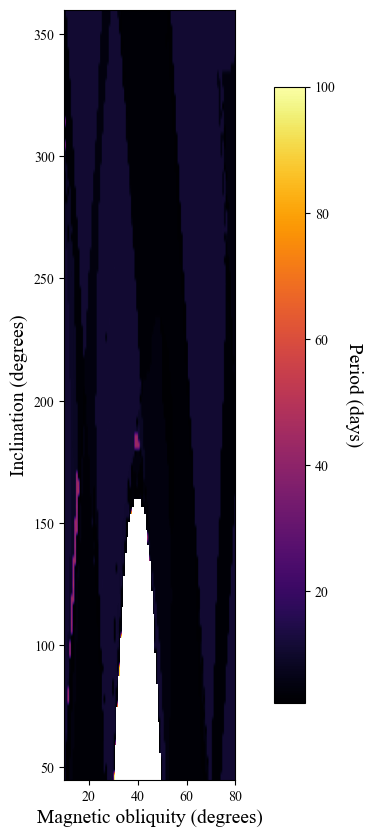

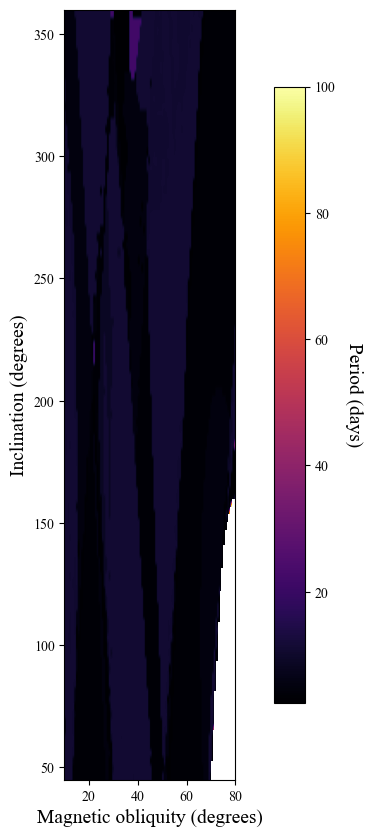

In [ ]:
plt.figure(figsize=(10,10))
# north
plt.imshow(period_grid[:,:,0],interpolation=None, extent=[betas.min(),betas.max(),inclinations.min(),inclinations.max()],origin="lower", cmap=cm.inferno)
plt.xlabel('Magnetic obliquity (degrees)', fontsize=14)
plt.ylabel('Inclination (degrees)', fontsize=14)
cbar = plt.colorbar(shrink=0.8)
cbar.set_label('Period (days)', rotation=270, fontsize=14, labelpad=20)
plt.show()

plt.figure(figsize=(10,10))
# south
plt.imshow(period_grid[:,:,1],interpolation=None, extent=[betas.min(),betas.max(),inclinations.min(),inclinations.max()],origin="lower", cmap=cm.inferno)
plt.xlabel('Magnetic obliquity (degrees)', fontsize=14)
plt.ylabel('Inclination (degrees)', fontsize=14)
cbar = plt.colorbar(shrink=0.8)
cbar.set_label('Period (days)', rotation=270, fontsize=14, labelpad=20)
plt.show()

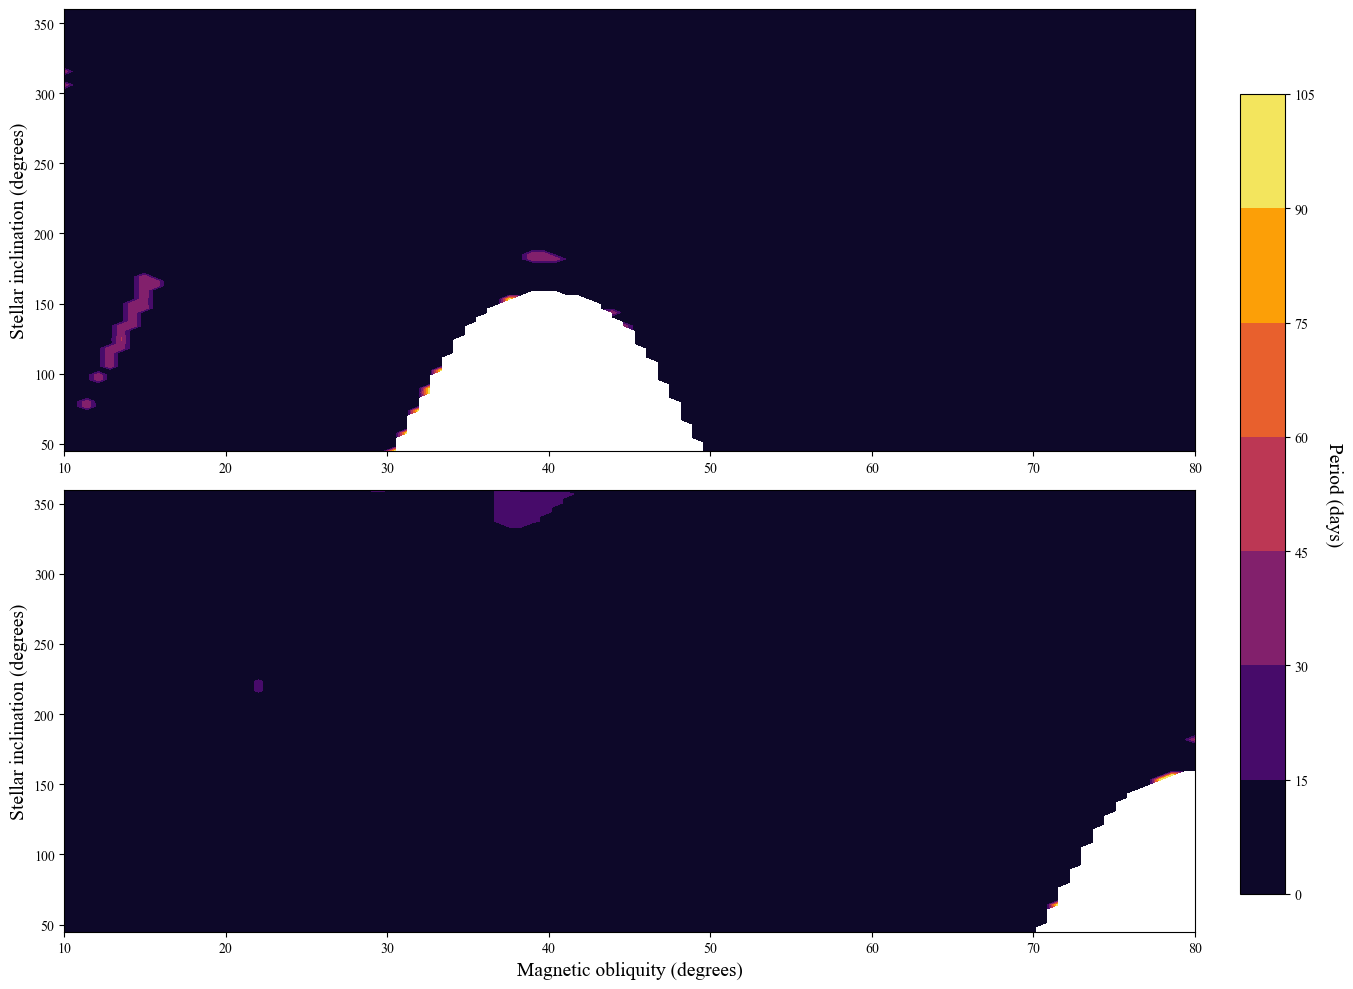

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
C1 = ax[0].contourf(betas, inclinations, period_grid[:,:,0], label='North', sharex=True, cmap = cm.inferno)
ax[1].set_xlabel('Magnetic obliquity (degrees)', fontsize=14)
ax[0].set_ylabel('Stellar inclination (degrees)', fontsize=14)
ax[1].set_ylabel('Stellar inclination (degrees)', fontsize=14)
C2 = ax[1].contourf(betas, inclinations, period_grid[:,:,1], label='South', cmap = cm.inferno)
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.1, 0.03, 0.8])
cbar = fig.colorbar(C1, cax=cbar_ax)
#cbar = plt.colorbar(C1)
#cbar = plt.colorbar(shrink=0.8)
cbar.set_label('Period (days)', rotation=270, fontsize=14, labelpad=20)
plt.show()

In [ ]:
print(period_grid[:,:,0]/P_p)

[[1.29892701 0.30361047 0.30367914 ... 1.28833243 1.29267391 1.2877146 ]
 [1.04553952 0.30357614 0.30367914 ... 1.29391971 1.29704474 1.29704474]
 [1.29018949 0.30357614 0.3036448  ... 1.28956987 1.2914305  1.2920519 ]
 ...
 [0.39632587 0.39585846 1.29704474 ... 1.29267391 1.29267391 1.29267391]
 [0.3964429  0.39585846 1.29516791 ... 1.29267391 1.29267391 1.29267391]
 [0.3967944  1.29641853 1.29579292 ... 1.29267391 1.29267391 1.29391971]]


In [ ]:
print(period_grid[:,:,0])

[[10.99286492  2.56946604  2.57004722 ... 10.90320259 10.93994464
  10.89797386]
 [ 8.84843765  2.56917555  2.57004722 ... 10.95048789 10.97693515
  10.97693515]
 [10.91891892  2.56917555  2.56975659 ... 10.91367511 10.92942167
  10.93468062]
 ...
 [ 3.35411977  3.35016401 10.97693515 ... 10.93994464 10.93994464
  10.93994464]
 [ 3.35511018  3.35016401 10.96105149 ... 10.93994464 10.93994464
  10.93994464]
 [ 3.35808489 10.97163549 10.96634093 ... 10.93994464 10.93994464
  10.95048789]]


nan
